In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import scipy
from skimage import color, filters, exposure, measure, morphology, util
from segmentflow import segment, view
%load_ext autoreload
%autoreload 2

## Load images

Loading images...
--> Images loaded as 3D array:  (996, 1014, 994)
Plotting images: [250, 500, 750]


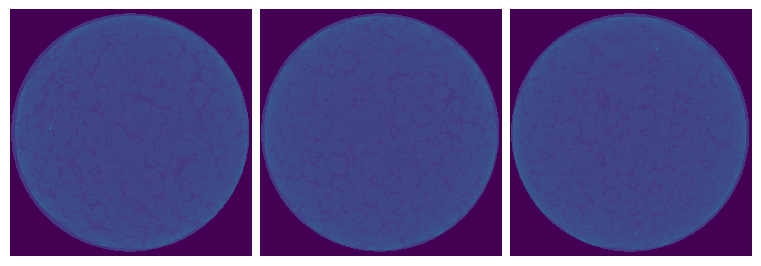

In [2]:
imgs_path = Path('../data/F83_01_raw')
slices = [250, 500, 750]
imgs = segment.load_images(
    imgs_path,
    slice_crop=None,
    # convert_to_float=True,
    file_suffix='.tiff'
)
fig, axes = view.plot_slices(
    imgs,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

In [3]:
preview_rescale = False
if preview_rescale:
    imgs_med = segment.preprocess(imgs, median_filter=True)
    med_hist, med_bins_centers = exposure.histogram(imgs_med)
    fig, ax = plt.subplots()
    ax.plot(med_bins_centers, med_hist)
    lo = np.percentile(imgs_med, 25.5)
    hi = np.percentile(imgs_med, 99.98)
    fig, ax = plt.subplots()
    ax.plot(med_bins_centers, med_hist)
    ax.axvline(lo, c='red')
    ax.axvline(hi, c='red')
    plt.show()

## Rescale intensity

Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [25.5, 99.98]...
--> Preprocessing complete.
Plotting images: [250, 500, 750]


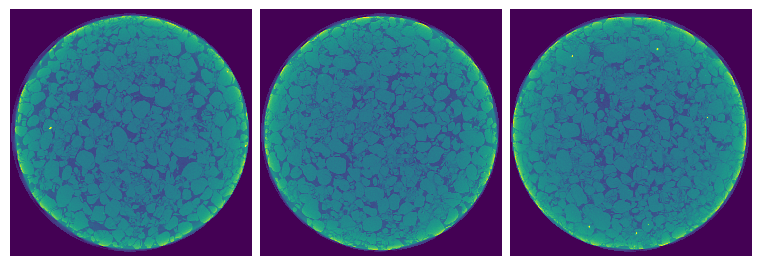

In [4]:
imgs_med = None
imgs_pre = segment.preprocess(
    imgs, median_filter=True, rescale_intensity_range=[25.5, 99.98])
fig, axes = view.plot_slices(
    imgs_pre,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

In [5]:
# segment.save_images(imgs_med, Path('../data/F83_01_pre'))

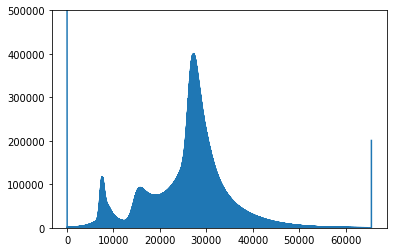

In [6]:
hist, bins_centers = exposure.histogram(imgs_pre)
fig, ax = plt.subplots()
ax.plot(bins_centers, hist)
ax.set_ylim([0, 5e5])
plt.show()

Calculating thresholds from local minima...
--> 3 peak(s) found: [7808, 16256, 27520]
--> 2 minima found: [11904, 19072]


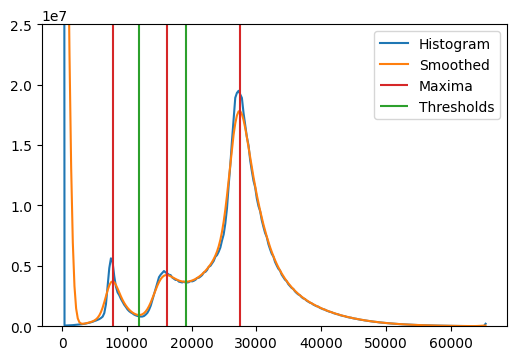

In [7]:
thresholds, fig, ax = segment.threshold_multi_min(
    imgs_pre, nbins=256, nthresholds='all', return_fig_ax=True,
    ylims=[0, 2.5e7], plt_kwargs={'dpi': 100})
plt.show()

## Failed semantic seg

Plotting images: [250, 500, 750]


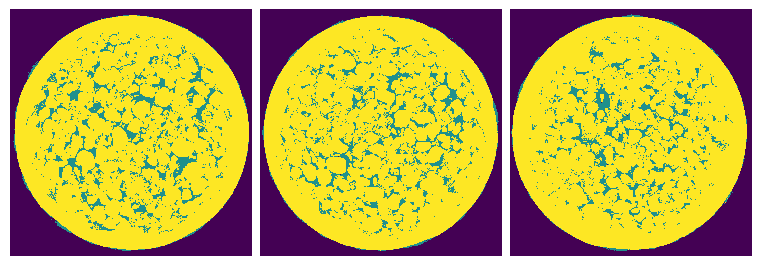

imgs_semantic = 0


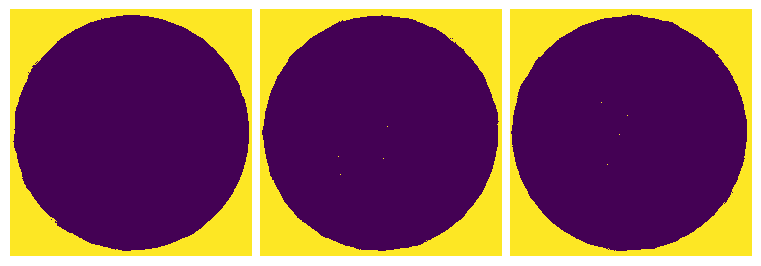

imgs_semantic = 1


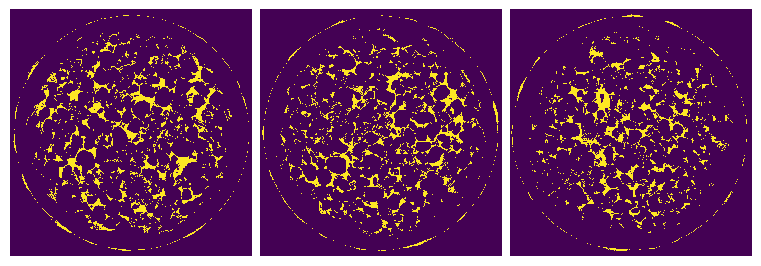

imgs_semantic = 2


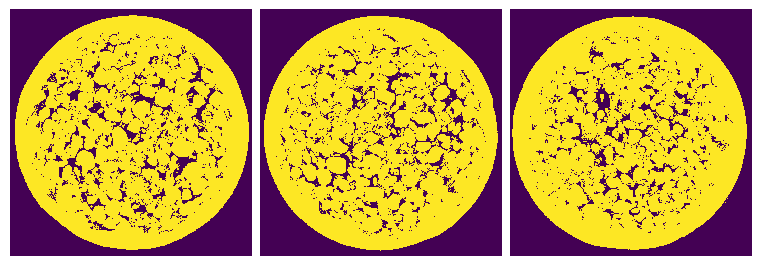

In [8]:
imgs_semantic = segment.isolate_classes(imgs_pre, thresholds)
fig, axes = view.plot_slices(imgs_semantic, slices=slices)
plt.show()
for i in range(len(thresholds) + 1):
    print('imgs_semantic =', i)
    fig, axes = view.plot_slices(
        imgs_semantic==i,
        slices=slices,
        print_slices=False,
        fig_w=7.5,
        dpi=100
    )
    plt.show()

Segmenting images...
--> Number of particle(s) before border exclusion:  16526
--> Excluding border particles...
--> Segmentation complete. 15662 particle(s) segmented.


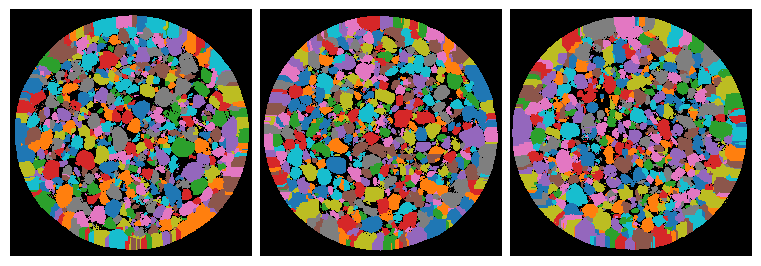

In [9]:
imgs = None
imgs_med = None
imgs_res = None
imgs_labeled = segment.watershed_segment(
    imgs_semantic==len(thresholds),
    min_peak_distance=6,
    exclude_borders=True,
    return_dict=False
)
fig, axes = view.plot_color_labels(
    imgs_labeled,
    slices=slices,
    fig_w=7.5,
    dpi=100
)

In [25]:
imgs_labeled_unique = np.unique(imgs_labeled)
print(f'{imgs_labeled_unique.shape=}')
print(f'{imgs_labeled_unique[:10]=}')

imgs_labeled_unique.shape=(15663,)
imgs_labeled_unique[:10]=array([  0, 645, 646, 647, 651, 652, 653, 654, 655, 656], dtype=uint16)


In [10]:
merged_labels_dir_path = Path('../results/F83_01_merged_labels')
imgs_merged = segment.merge_segmentations(imgs_semantic, imgs_labeled)
segment.save_images(imgs_merged, merged_labels_dir_path)

996 image(s) saved to: C:\Users\gusb\Research\mhe-analysis\nbs\results\F83_01_merged_labels


Loading images...
--> Images loaded as 3D array:  (996, 1014, 994)


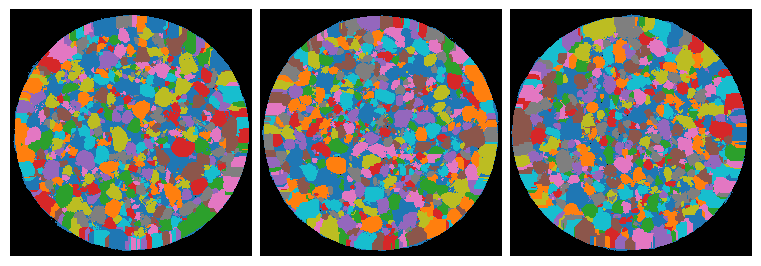

In [29]:
merged_labels_dir_path = Path('C:/Users/gusb/Documents/00-research-docs/F83_01_merged_labels')
imgs_merged = segment.load_images(merged_labels_dir_path, file_suffix='.tif')
fig, axes = view.plot_color_labels(
    imgs_merged,
    slices=slices,
    fig_w=7.5,
    dpi=100
)
plt.show()

In [30]:
imgs_merged_unique = np.unique(imgs_merged)
print(f'{imgs_merged_unique.shape=}')
print(f'{imgs_merged_unique[:10]=}')
print(f'{imgs_merged_unique[-1]=}')

imgs_merged_unique.shape=(15664,)
imgs_merged_unique[:10]=array([  0,   1, 645, 646, 647, 651, 652, 653, 654, 655], dtype=uint16)
imgs_merged_unique[-1]=16526
